In [1]:
import sys
sys.path.append( '../Model/' )
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch
from torch_geometric.utils import from_networkx
import networkx as nx
from vq_vae_f import *
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling

In [2]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [3]:
hidden_dim = 64
latent_dim = 64
num_latent = 30
prior_alpha  = 1
prior_beta = 2
beta = 0.25
p_input_dim = 15
lr = 5e-2
torch.manual_seed(2000)
# Initial data
x = torch.randn(data.num_nodes,p_input_dim)
f_input_dim = data.num_node_features
f = data.x

# model
torch.manual_seed(2000)

model = sb_vq_vae_f(p_input_dim, f_input_dim, hidden_dim, latent_dim, num_latent, beta, prior_alpha, prior_beta, number_of_classes=dataset.num_classes,training=True)
# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
f = f.to(device)
x = x.to(device)

edge_index = data.edge_index.to(device)
# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

In [4]:
criterion = torch.nn.CrossEntropyLoss()

/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Epoch:010, loss:0.8355, acc:0.4830
Epoch:020, loss:0.5363, acc:0.4910
Epoch:030, loss:0.5555, acc:0.6110
Epoch:040, loss:0.0674, acc:0.6110
Epoch:050, loss:0.0144, acc:0.6110
Epoch:060, loss:0.0259, acc:0.6110
Epoch:070, loss:0.0052, acc:0.6110
Epoch:080, loss:0.0115, acc:0.6110
Epoch:090, loss:0.0048, acc:0.6110
Epoch:100, loss:0.0061, acc:0.6110
Epoch:110, loss:0.0047, acc:0.6110
Epoch:120, loss:0.0042, acc:0.6110
Epoch:130, loss:0.0039, acc:0.6110
Epoch:140, loss:0.0035, acc:0.6110
Epoch:150, loss:0.0032, acc:0.6110
Epoch:160, loss:0.0030, acc:0.6110
Epoch:170, loss:0.0028, acc:0.6110
Epoch:180, loss:0.0026, acc:0.6110
Epoch:190, loss:0.0024, acc:0.6110
Epoch:200, loss:0.0023, acc:0.6110
Epoch:210, loss:0.0022, acc:0.6110
Epoch:220, loss:0.0020, acc:0.6110
Epoch:230, loss:0.0019, acc:0.6110
Epoch:240, loss:0.0018, acc:0.6110
Epoch:250, loss:0.0017, acc:0.6110
Epoch:260, loss:0.0017, acc:0.6110
Epoch:270, loss:0.0016, acc:0.6110
Epoch:280, loss:0.0015, acc:0.6110
Epoch:290, loss:0.00

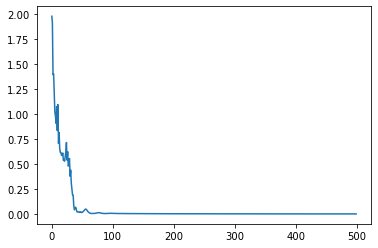

In [5]:
def train(epoch):
    model.train()
    recon_p_loss, recon_f_loss, kl_prior_loss_p, kl_prior_loss_f, vq_loss_p, vq_loss_f, output = model(x, f, edge_index, neg_edge_index=None)
    optimizer.zero_grad()
    unsup_loss =  recon_p_loss  +  recon_f_loss  + kl_prior_loss_p  + kl_prior_loss_f + vq_loss_p + vq_loss_f # +  0.001 * kl_cat_loss  + 0.001 * torch.abs(kl_kumar_loss)
    sup_loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss = unsup_loss + sup_loss
    loss.backward()
    optimizer.step()
    # for name, params in model.named_parameters():
    #     print(name, eval('model.'+name).grad)
    # for name, parma in model.named_parameters():
    #     print(name, eval('model.'+name).grad, parma.shape)
    return float(sup_loss), output

def test():
    model.eval()
    recon_p_loss, recon_f_loss, kl_prior_loss_p, kl_prior_loss_f, vq_loss_p, vq_loss_f, output = model(x, f, edge_index, neg_edge_index=None)
    pred = output.argmax(dim=1)  
    test_correct = pred[data.test_mask] == data.y[data.test_mask] 
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
    return test_acc

epochs = 500
loss_min = torch.tensor([100000])
rec = []
prior1_rec = []
recon_rec = []
acc_max = 0


for epoch in range(1, epochs + 1):
    loss, output = train(epoch)
    rec.append(float(loss))
    acc = test()
    if acc > acc_max:
        acc_max = acc
    # prior1_rec.append(float(kl_prior1_loss))
    # recon_rec.append(float(recon_loss))
    # for name, param in model.named_parameters():
    #     print(name, eval('model.'+name).grad)
    if epoch % 10 == 0:
        print('Epoch:{:03d}, loss:{:.4f}, acc:{:.4f}'.format(epoch, loss, acc_max))
        # print(quantized_latents[0,:])
        # for p in model.parameters():
        #     print(p[:,0])
# plt.plot(prior1_rec)
plt.plot(rec)

In [19]:
hidden_dim = 64
latent_dim = 64
num_latent = 30
prior_alpha  = 1
prior_beta = 2
beta = 0.25
p_input_dim = 15
lr = 5e-2
torch.manual_seed(2000)
# Initial data
x = torch.randn(data.num_nodes,p_input_dim)
f_input_dim = data.num_node_features
f = data.x

# model
torch.manual_seed(2000)

model = sb_vq_vae_f(p_input_dim, f_input_dim, hidden_dim, latent_dim, num_latent, beta, prior_alpha, prior_beta, number_of_classes=dataset.num_classes,training=True)
# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
f = f.to(device)
x = x.to(device)

edge_index = data.edge_index.to(device)
# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

Epoch:001, loss:1.9806, acc:0.2580
Epoch:002, loss:2.0263, acc:0.3260
Epoch:003, loss:1.2969, acc:0.3390
Epoch:004, loss:0.9575, acc:0.5100
Epoch:005, loss:0.7416, acc:0.5280
Epoch:006, loss:0.5663, acc:0.5280
Epoch:007, loss:0.4795, acc:0.5280
Epoch:008, loss:0.2960, acc:0.5340
Epoch:009, loss:0.2651, acc:0.5700
Epoch:010, loss:0.1283, acc:0.6070
Epoch:011, loss:0.0865, acc:0.6470
Epoch:012, loss:0.0598, acc:0.6490
Epoch:013, loss:0.0598, acc:0.6490
Epoch:014, loss:0.0132, acc:0.6660
Epoch:015, loss:0.0039, acc:0.6780
Epoch:016, loss:0.0146, acc:0.6900
Epoch:017, loss:0.0112, acc:0.7080
Epoch:018, loss:0.0074, acc:0.7180
Epoch:019, loss:0.0030, acc:0.7230
Epoch:020, loss:0.0014, acc:0.7230
Epoch:021, loss:0.0005, acc:0.7230
Epoch:022, loss:0.0003, acc:0.7250
Epoch:023, loss:0.0004, acc:0.7250
Epoch:024, loss:0.0003, acc:0.7250
Epoch:025, loss:0.0002, acc:0.7250
Epoch:026, loss:0.0001, acc:0.7250
Epoch:027, loss:0.0001, acc:0.7250
Epoch:028, loss:0.0001, acc:0.7250
Epoch:029, loss:0.00

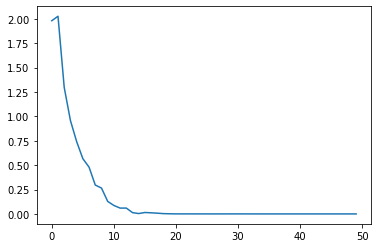

In [20]:
criterion = torch.nn.CrossEntropyLoss()
def train(epoch):
    model.train()
    recon_p_loss, recon_f_loss, kl_prior_loss_p, kl_prior_loss_f, vq_loss_p, vq_loss_f, output = model(x, f, edge_index, neg_edge_index=None)
    optimizer.zero_grad()
    unsup_loss =  recon_p_loss  +  recon_f_loss  + kl_prior_loss_p  + kl_prior_loss_f + vq_loss_p + vq_loss_f # +  0.001 * kl_cat_loss  + 0.001 * torch.abs(kl_kumar_loss)
    sup_loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss = sup_loss
    loss.backward()
    optimizer.step()
    # for name, params in model.named_parameters():
    #     print(name, eval('model.'+name).grad)
    # for name, parma in model.named_parameters():
    #     print(name, eval('model.'+name).grad, parma.shape)
    return float(loss), output

def test():
    model.eval()
    recon_p_loss, recon_f_loss, kl_prior_loss_p, kl_prior_loss_f, vq_loss_p, vq_loss_f, output = model(x, f, edge_index, neg_edge_index=None)
    pred = output.argmax(dim=1)  
    test_correct = pred[data.test_mask] == data.y[data.test_mask] 
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
    return test_acc

epochs = 50
loss_min = torch.tensor([100000])
rec = []
prior1_rec = []
recon_rec = []
acc_max = 0


for epoch in range(1, epochs + 1):
    loss, output = train(epoch)
    rec.append(float(loss))
    acc = test()
    if acc > acc_max:
        acc_max = acc
    # prior1_rec.append(float(kl_prior1_loss))
    # recon_rec.append(float(recon_loss))
    # for name, param in model.named_parameters():
    #     print(name, eval('model.'+name).grad)
    if epoch % 1 == 0:
        print('Epoch:{:03d}, loss:{:.4f}, acc:{:.4f}'.format(epoch, loss, acc_max))
        # print(quantized_latents[0,:])
        # for p in model.parameters():
        #     print(p[:,0])
# plt.plot(prior1_rec)
plt.plot(rec)